# Continuous Data A/B Test using Bayesian Statistics

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import pymc as pm
import arviz as az
import numpy
import pymc
import pandas as pd

## Website data for control & variant of the site

Here, our hypothesis is:

&emsp; $H_{0}$: With the variant, there is no change

&emsp; $H_{1}$: With the variant, we see a change by x%

# Content

1. [Read Data](#read_data)
2. [Frequentist Tests](#frequentist_test)
3. [A/B Test for Control and Test Samples](#test1_ab)
4. [Adding a few outliers to Test Period](#test2_add_outlier)
    * [Run the model with 2 outliers](#run2_with_outlier)
5. [Conclusion](#conclusion)
    * [Bayesian Statistics Conclusion](#bayesian_stat_conclusion)

## 1. Read data
<a id="read_data"></a>

These are two generated data sets from normal distribution for:
* mu = 15, std_dev = 15, keeping only positive numbers
* mu = 13, std_dev = 17, keeping only positive numbers

This is to simulate data that can be only positive such as work time duration for a particular process or auction prices for certain products, etc.

In [2]:
df_control = pd.read_csv('../data/half_normal_data_mu15_std15.csv')
df_control.head()

,session,rate
0,0,12.465066
1,1,29.124034
2,2,12.418092
3,3,21.618755
4,4,10.789454


In [3]:
df_test= pd.read_csv('../data/half_normal_data_mu13_std15.csv')
df_test.head()

,session,rate
0,0,1.636872
1,1,24.860388
2,2,12.369456
3,3,29.880620
4,4,14.867301


In [4]:
# Common Sense Check
print("FAP Minutes")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (df_control['rate'].mean(), df_control['rate'].std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (df_test['rate'].mean(), df_test['rate'].std()))

FAP Minutes
   Control (A):  mean =  18.909599  std dev =  11.842676
   Test    (B):  mean =  16.414283  std dev =  11.381074


In [5]:
def plot_posterior_side_by_side(conv_a, conv_b, graph_title):
    plt.figure(figsize=(10, 6))

    # plt.subplot(1, 2, 1)
    plt.hist(conv_a, bins=35, histtype='stepfilled', 
    color='#da6d75', label='Conversion A',alpha=0.5)
    plt.legend()

    plt.hist(conv_b, bins=35, histtype='stepfilled',
    color='#52c4a8', label='Conversion B',alpha=0.5)
    # plt.title('Posterior Lift')
    plt.title(graph_title)
    plt.legend()

    plt.show()

In [6]:
def t_test_6_ways(data_a, data_b):
    
    # Assume the variance of the 2 datasets are equal: 2-tail test
    print('Difference in means T-Tests')
    print('   Equal Var & Two Sided:', sps.ttest_ind(a=data_a, b=data_b, equal_var=True, alternative="two-sided"))

    #   1-tail test less than
    print('   Equal Var & A < B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=True, alternative="less"))
    
    #   1-tail test greater than
    print('   Equal Var & A > B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=True, alternative="greater"), '\n')
    
    # Assume the variance of the 2 datasets are NOT equal: 2-tail test
    print('   Not-Equal Var & Two Sided:', sps.ttest_ind(a=data_a, b=data_b, equal_var=False, alternative="two-sided"))

    #   1-tail test less than
    print('   Not-Equal Var & A < B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=False, alternative="less"))
    
    #   1-tail test greater than
    print('   Not-Equal Var & A > B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=False, alternative="greater"))

# Frequentist Tests
<a id="frequentist_test"></a>
Using our standard t-tests to determine if the mean of the revenue lift is different or less than (control < treatment) per our equal variance and two-sided/one-sided tests, we get:

In [7]:
t_test_6_ways(df_control['rate'], df_test['rate'])

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=1.9467289561575793, pvalue=0.052423253968572975)
   Equal Var & A < B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.9737883730157135)
   Equal Var & A > B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.026211626984286487) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=1.9488527243895295, pvalue=0.052168109070952026)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.973915945464524)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.026084054535476013)


## Build a model

Distribution Explorer https://distribution-explorer.github.io

## Test 1: A/B Test for Control and Test Samples
<a id="test1_ab"></a>

In [8]:
with pm.Model() as ab_model:
    
    # PRIORs
    continuous_data_prior_a = pm.distributions.continuous.Normal('conversion_data_A', mu=30, sigma=5)
    continuous_data_prior_b = pm.distributions.continuous.Normal('conversion_data_B', mu=30, sigma=5)
    
    # Likelihood of observing data given parameter
    how_likely_a = pm.Poisson('likelihood_A', continuous_data_prior_a, observed=df_control['rate'])
    how_likely_b = pm.Poisson('likelihood_B', continuous_data_prior_b, observed=df_test['rate'])
    
    # POSTERIORs
    #   conversion_A
    #   conversion_B
    #   conv_lift
    conv_a = pm.Deterministic('conversion_A', continuous_data_prior_a)
    conv_b = pm.Deterministic('conversion_B', continuous_data_prior_b)
    
    # Calculate lift difference
    pm.Deterministic('conv_lift', conv_a - conv_b)   
    
    # Hit the magical inference button
    step = pm.Slice()
    trace = pm.sample(5000, step=step, tune=500, random_seed=8888, progressbar=True)
    
    # pm.Metropolis()
    # trace = pm.sample(10000, step=step, tune=500, random_seed=42, progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [conversion_data_A]
>Slice: [conversion_data_B]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 51 seconds.


In [9]:
# FAP Posterior Predictive Values
post_conversion_a = trace.posterior.stack(draws=("chain", "draw"))["conversion_data_A"].values 
post_conversion_b = trace.posterior.stack(draws=("chain", "draw"))["conversion_data_B"].values
print(post_conversion_a[0:5], post_conversion_b[0:5])

# Relative Lift
conversion_lift = trace.posterior.stack(draws=("chain", "draw"))["conv_lift"].values
print(conversion_lift[0:5])

[18.66628515 18.60592525 18.94005257 18.4682675  18.21222453] [15.78552255 16.01012684 15.83902422 15.9166824  16.49168981]
[2.8807626  2.59579841 3.10102835 2.5515851  1.72053472]


In [10]:
print(post_conversion_a.mean(), post_conversion_b.mean())

18.47504810608488 16.009811544296817


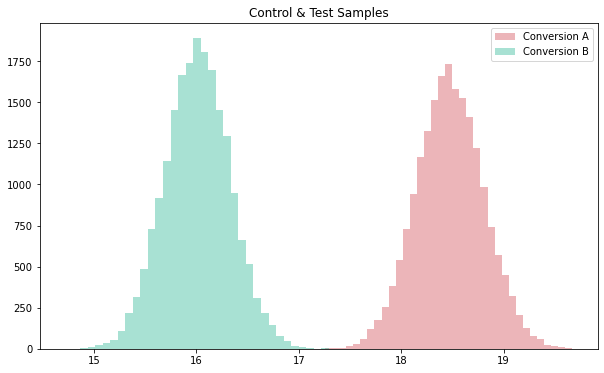

In [11]:
plot_posterior_side_by_side(post_conversion_a, post_conversion_b, 'Control & Test Samples')

Text(0.5, 1.0, 'Conversion Lift')

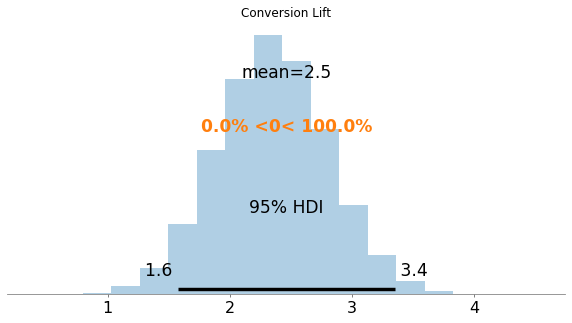

In [12]:
ax = az.plot_posterior(trace, var_names = ['conv_lift'], kind='hist', 
                  hdi_prob = 0.95, ref_val=0, textsize = 16, figsize=(10, 5))

ax.set_title('Conversion Lift')

In [13]:
print('Probability of Conversion Lift (treatment > control) = %.6f' % ((conversion_lift > 0).mean()))

Probability of Conversion Lift (treatment > control) = 1.000000


In [14]:
# Posterior Mean & Variance
print("FAP Minutes")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (post_conversion_a.mean(), post_conversion_a.std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (post_conversion_b.mean(), post_conversion_b.std()))

FAP Minutes
   Control (A):  mean =  18.475048  std dev =   0.328782
   Test    (B):  mean =  16.009812  std dev =   0.316303


In [15]:
# Common Sense Check
print("FAP Minutes")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (df_control['rate'].mean(), df_control['rate'].std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (df_test['rate'].mean(), df_test['rate'].std()))

FAP Minutes
   Control (A):  mean =  18.909599  std dev =  11.842676
   Test    (B):  mean =  16.414283  std dev =  11.381074


In [16]:
t_test_6_ways(df_control['rate'], df_test['rate'])

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=1.9467289561575793, pvalue=0.052423253968572975)
   Equal Var & A < B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.9737883730157135)
   Equal Var & A > B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.026211626984286487) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=1.9488527243895295, pvalue=0.052168109070952026)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.973915945464524)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.026084054535476013)


In [17]:
df_test

,session,rate
0,0,1.636872
1,1,24.860388
2,2,12.369456
3,3,29.880620
4,4,14.867301
...,...,...
155,155,29.233537
156,156,7.299605
157,157,41.128513
158,158,16.995962


## Test 2: Adding a few outliers to Test Period
<a id="test2_add_outlier"></a>

In [18]:
# Look at the summary stats for df_control['rate']
df_control['rate'].describe()

count    169.000000
mean      18.909599
std       11.842676
min        0.099608
25%       10.485982
50%       18.370997
75%       25.558300
max       60.280997
Name: rate, dtype: float64

In [19]:
# Look at the summary stats for df_test['rate']
df_test['rate'].describe()

count    160.000000
mean      16.414283
std       11.381074
min        0.167529
25%        7.533133
50%       14.945854
75%       23.025342
max       57.324484
Name: rate, dtype: float64

In [20]:
df_test.tail()

,session,rate
155,155,29.233537
156,156,7.299605
157,157,41.128513
158,158,16.995962
159,159,19.241780


In [21]:
# Add 2 outlier data points which are slightly higher than the max for df_test2

dict1 = {"session" : [160, 161],
         "rate"    : [75 , 80]}

df_temp = pd.DataFrame(dict1, index=[len(df_test), len(df_test)+1])
df_temp

,session,rate
160,160,75
161,161,80


In [22]:
df_test2 = pd.concat([df_test, df_temp])
df_test2.tail()

,session,rate
157,157,41.128513
158,158,16.995962
159,159,19.241780
160,160,75.000000
161,161,80.000000


In [23]:
# Common Sense Check
print("FAP Minutes")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (df_control['rate'].mean(), df_control['rate'].std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (df_test['rate'].mean(), df_test['rate'].std()))
print("   Test2  (B2):  mean = %10.6f  std dev = %10.6f" % (df_test2['rate'].mean(), df_test2['rate'].std()))

FAP Minutes
   Control (A):  mean =  18.909599  std dev =  11.842676
   Test    (B):  mean =  16.414283  std dev =  11.381074
   Test2  (B2):  mean =  17.168428  std dev =  13.182518


In [24]:
# After the 2 outlier data points were added to df_test2

t_test_6_ways(df_control['rate'], df_test2['rate'])

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=1.2651827961421163, pvalue=0.2067011494561381)
   Equal Var & A < B    : Ttest_indResult(statistic=1.2651827961421163, pvalue=0.8966494252719309)
   Equal Var & A > B    : Ttest_indResult(statistic=1.2651827961421163, pvalue=0.10335057472806905) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=1.2623204887791464, pvalue=0.20774736286625134)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=1.2623204887791464, pvalue=0.8961263185668743)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=1.2623204887791464, pvalue=0.10387368143312567)


In [25]:
# Recall the T-tests with original data

t_test_6_ways(df_control['rate'], df_test['rate'])

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=1.9467289561575793, pvalue=0.052423253968572975)
   Equal Var & A < B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.9737883730157135)
   Equal Var & A > B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.026211626984286487) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=1.9488527243895295, pvalue=0.052168109070952026)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.973915945464524)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.026084054535476013)


### Run the model with 2 outliers
<a id="run2_with_outlier"></a>

In [26]:
with pm.Model() as ab_model2:

    # PRIORs
    continuous_data_prior_a = pm.distributions.continuous.Normal('conversion_data_A', mu=30, sigma=5)
    continuous_data_prior_b = pm.distributions.continuous.Normal('conversion_data_B', mu=30, sigma=5)
    
    # Likelihood of observing data given parameter
    how_likely_a = pm.Poisson('likelihood_A', continuous_data_prior_a, observed=df_control['rate'])
    how_likely_b = pm.Poisson('likelihood_B', continuous_data_prior_b, observed=df_test2['rate'])
    
    # POSTERIORs
    #   conversion_A
    #   conversion_B
    #   conv_lift
    conv_a = pm.Deterministic('conversion_A', continuous_data_prior_a)
    conv_b = pm.Deterministic('conversion_B', continuous_data_prior_b)
    
    # Calculate lift difference
    pm.Deterministic('conv_lift', conv_a - conv_b)
    
    # trace = pm.sample(5000, step=step, tune=500, random_seed=8888, progressbar=True)
    step = pm.Slice()
    
    # Hit the magical inference button
    trace2 = pm.sample(step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [conversion_data_A]
>Slice: [conversion_data_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


In [27]:
# FAP Posterior Predictive Values
post_conversion_a2 = trace2.posterior.stack(draws=("chain", "draw"))["conversion_data_A"].values 
post_conversion_b2 = trace2.posterior.stack(draws=("chain", "draw"))["conversion_data_B"].values
print(post_conversion_a2[0:5], post_conversion_b2[0:5])

# Relative Lift
conversion_lift2 = trace2.posterior.stack(draws=("chain", "draw"))["conv_lift"].values
print(conversion_lift[0:5])

[18.08115905 18.78505083 18.45453346 19.04008352 18.92754392] [16.65849004 17.0390354  16.54262485 17.00097171 16.84661024]
[2.8807626  2.59579841 3.10102835 2.5515851  1.72053472]


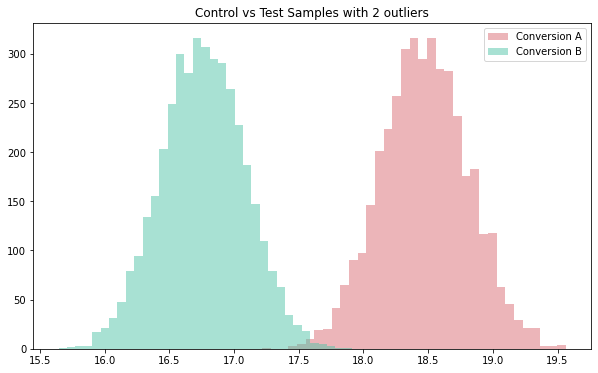

In [28]:
plot_posterior_side_by_side(post_conversion_a2, post_conversion_b2, 'Control vs Test Samples with 2 outliers')

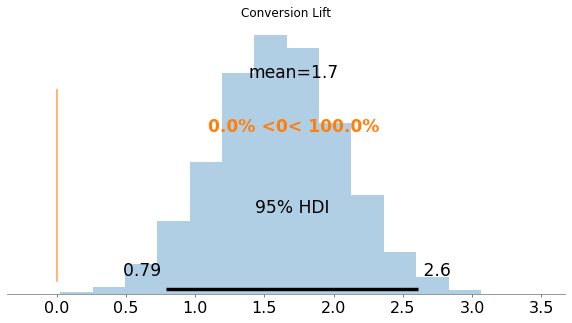

In [29]:
ax = az.plot_posterior(trace2, var_names = ['conv_lift'], kind='hist', 
                  hdi_prob = 0.95, ref_val=0, textsize = 16, figsize=(10, 5))

ax.set_title('Conversion Lift')
plt.show()

In [30]:
print('Probability of Conversion Lift (treatment > control) = %.6f' % ((conversion_lift > 0).mean()))
print('Probability of Conversion Lift (treatment < control) = %.6f' % ((conversion_lift < 0).mean()))

Probability of Conversion Lift (treatment > control) = 1.000000
Probability of Conversion Lift (treatment < control) = 0.000000


In [31]:
# Posterior Conversion Rate
print("FAP Minutes")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (post_conversion_a.mean(), post_conversion_a.std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (post_conversion_b.mean(), post_conversion_b.std()))

FAP Minutes
   Control (A):  mean =  18.475048  std dev =   0.328782
   Test    (B):  mean =  16.009812  std dev =   0.316303


In [32]:
# Common Sense Check
print("FAP Minutes")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (df_control['rate'].mean(), df_control['rate'].std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (df_test2['rate'].mean(), df_test2['rate'].std()))

FAP Minutes
   Control (A):  mean =  18.909599  std dev =  11.842676
   Test    (B):  mean =  17.168428  std dev =  13.182518


# Conclusion
<a id="conclusion"></a>
By adding 2 some what larger data points, frequentist t-stats changed.  Recall the original t-stats for control and test.

In [33]:
t_test_6_ways(df_control['rate'], df_test['rate'])

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=1.9467289561575793, pvalue=0.052423253968572975)
   Equal Var & A < B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.9737883730157135)
   Equal Var & A > B    : Ttest_indResult(statistic=1.9467289561575793, pvalue=0.026211626984286487) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=1.9488527243895295, pvalue=0.052168109070952026)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.973915945464524)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=1.9488527243895295, pvalue=0.026084054535476013)


In the test where control rate > test rate in both equal or non-equal variances, we can reject the 
null hypothesis that the two sample means are equal.

Now, let's look at the t-stats for control and test2 (with 2 outlier data points added).

In [34]:
t_test_6_ways(df_control['rate'], df_test2['rate'])

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=1.2651827961421163, pvalue=0.2067011494561381)
   Equal Var & A < B    : Ttest_indResult(statistic=1.2651827961421163, pvalue=0.8966494252719309)
   Equal Var & A > B    : Ttest_indResult(statistic=1.2651827961421163, pvalue=0.10335057472806905) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=1.2623204887791464, pvalue=0.20774736286625134)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=1.2623204887791464, pvalue=0.8961263185668743)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=1.2623204887791464, pvalue=0.10387368143312567)


With the new Test2 data, we can no longer reject the null hypothesis that the means are equal at p=0.05.  
That is quite a change by adding 2 outlier data points that are slightly higher than the max of Test2!

Now, let's examine the Bayesian stats instead.

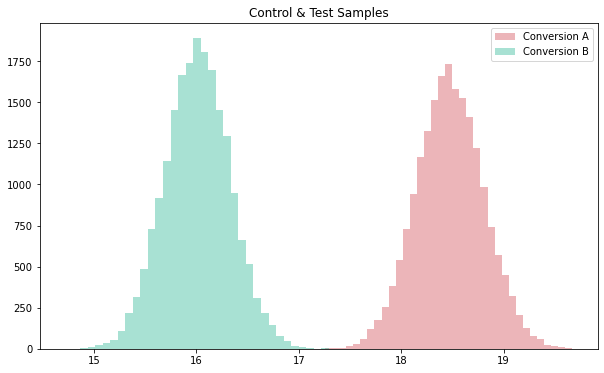

In [35]:
plot_posterior_side_by_side(post_conversion_a, post_conversion_b, 'Control & Test Samples')

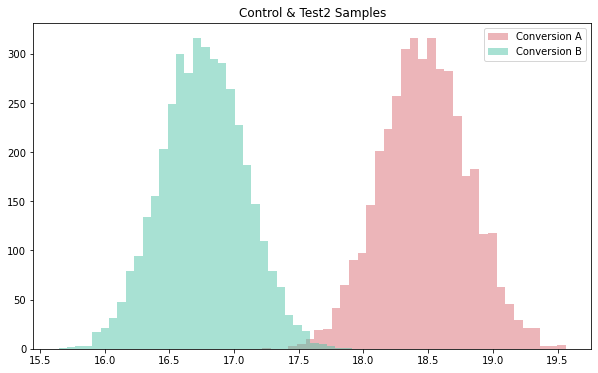

In [36]:
plot_posterior_side_by_side(post_conversion_a2, post_conversion_b2, 'Control & Test2 Samples')

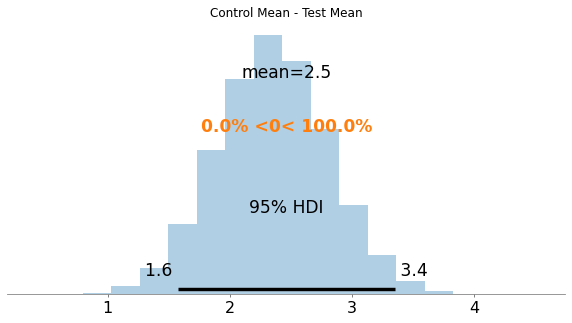

In [37]:
ax = az.plot_posterior(trace, var_names = ['conv_lift'], kind='hist', 
                  hdi_prob = 0.95, ref_val=0, textsize = 16, figsize=(10, 5))

ax.set_title('Control Mean - Test Mean')
plt.show()

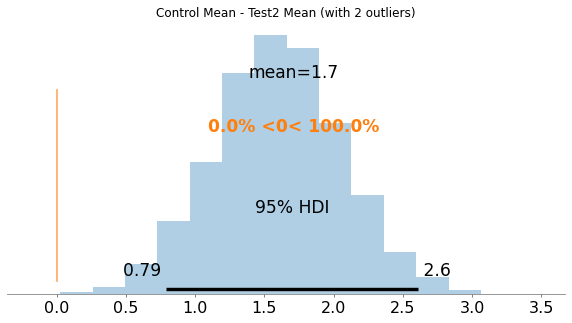

In [38]:
ax = az.plot_posterior(trace2, var_names = ['conv_lift'], kind='hist', 
                  hdi_prob = 0.95, ref_val=0, textsize = 16, figsize=(10, 5))

ax.set_title('Control Mean - Test2 Mean (with 2 outliers)')
plt.show()

### Bayesian Statistics
<a id="bayesian_stat_conclusion"></a>
With Bayesian sampling, the original (control mean - test mean) > 0 with a very high probability. 
The difference in means is at around 2.5 with the a credible interval betwen 1.6 to 3.4

With the 2 outlier data points added, the Bayesian sampling continues to give 
(control mean - test mean) > 0 with a 
high probablity.  However, the difference is means is lower at at around 1.7 with a credible interval between 0.82 to 2.6.

We know the average (e.g. arithmetic mean) and standard deviation can be somewhat sensitive to outliers especially 
with smaller sample sizes.  In this case, I know that we cannot use t-stats because the generated data is not normally distributed. Check out the other notebook to test whether the data violates the normally distributed assumption.

From this perspective, Bayesian sampling gives a more robust result which does not require a data distribution assumption amongst other things.  